In [10]:
import sys, os, re, gzip, json, pickle, shutil, random, joblib

import torch
import torch.nn as nn
import torch.functional as F

import numpy as np
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

#from fse.models import SIF
#from fse import IndexedList

import librosa
import librosa.display

import soundfile as sf

%matplotlib inline

In [2]:
import sys
!{sys.executable} -m pip install gensim==3.8.3

    ERROR: Command errored out with exit status 1:
     command: 'c:\ml\env\scripts\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Collins\\AppData\\Local\\Temp\\pip-install-1913f6it\\gensim_074849f308364a74a3de9cb42aa51304\\setup.py'"'"'; __file__='"'"'C:\\Users\\Collins\\AppData\\Local\\Temp\\pip-install-1913f6it\\gensim_074849f308364a74a3de9cb42aa51304\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record 'C:\Users\Collins\AppData\Local\Temp\pip-record-alh6wz9u\install-record.txt' --single-version-externally-managed --compile --install-headers 'c:\ml\env\include\site\python3.9\gensim'
         cwd: C:\Users\Collins\AppData\Local\Temp\pip-install-1913f6it\gensim_074849f308364a74a3de9cb42aa51304\
    Complete


  Using cached gensim-3.8.3.tar.gz (23.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for gensim, since package 'wheel' is not installed.
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2
    Running setup.py install for gensim: started
    Running setup.py install for gensim: finished with status 'error'
  Rolling back uninstall of gensim
  Moving to c:\ml\env\lib\site-packages\gensim-4.1.2.dist-info\
   from C:\ML\env\Lib\site-packages\~ensim-4.1.2.dist-info
  Moving to c:\ml\env\lib\site-packages\gensim\
   from C:\ML\env\Lib\site-packages\~ensim


    copying gensim\test\test_data\large_tag_doc_10_iter50 -> build\lib.win-amd64-3.9\gensim\test\test_data
    copying gensim\test\test_data\lda_3_0_1_model -> build\lib.win-amd64-3.9\gensim\test\test_data
    copying gensim\test\test_data\lda_3_0_1_model.expElogbeta.npy -> build\lib.win-amd64-3.9\gensim\test\test_data
    copying gensim\test\test_data\lda_3_0_1_model.id2word -> build\lib.win-amd64-3.9\gensim\test\test_data
    copying gensim\test\test_data\lda_3_0_1_model.state -> build\lib.win-amd64-3.9\gensim\test\test_data
    copying gensim\test\test_data\ldamodel_python_2_7 -> build\lib.win-amd64-3.9\gensim\test\test_data
    copying gensim\test\test_data\ldamodel_python_2_7.expElogbeta.npy -> build\lib.win-amd64-3.9\gensim\test\test_data
    copying gensim\test\test_data\ldamodel_python_2_7.id2word -> build\lib.win-amd64-3.9\gensim\test\test_data
    copying gensim\test\test_data\ldamodel_python_2_7.state -> build\lib.win-amd64-3.9\gensim\test\test_data
    copying gensim\test\t

In [4]:
import gensim

In [3]:
!{sys.executable} -m pip install fse

You should consider upgrading via the 'c:\ml\env\scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
from fse.models import SIF
from fse import IndexedList

ImportError: cannot import name 'BaseKeyedVectors' from 'gensim.models.keyedvectors' (c:\ml\env\lib\site-packages\gensim\models\keyedvectors.py)

#### Analyze melspec sound vectors to determine best way to perform dimensionality reduction, clustering, and/or quantization for downstream processing

In [4]:
data_path = '../data'
mp3com_path = '%s/mp3_com' % data_path

myspace_path = '%s/myspace_mp3s' % data_path
metadata_path = '%s/metadata.json.gz' % myspace_path
genre_map_path = '%s/genre_map.pkl' % myspace_path

features_path = '%s/audio_features' % data_path
melspec_path = '%s/melspec' % features_path
#melspec_path = 'melspec'

##### Extract melspec from samples and stack results together

In [69]:
def sound2vec():
    #embed(mp3com_path, feat_path=melspec_path, sample_rate=22050, n_mels=128, n_fft=2048, hop_length=512)
    
    xs = []
    for fn in os.listdir(melspec_path):
        if not fn.endswith('.npy'):
            continue
        fp = '%s/%s' % (melspec_path, fn)
        xs.append(np.load(fp).T)
    x = np.concatenate(xs)
    
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    x = x[idx,:]
    
    #create keyed vecs file
    sound_dict = {}
    sound_idx = 0
    with open('keyed_melspec_vecs.txt', 'w') as o:
        o.write('188050 128\n')
        for fn in os.listdir(melspec_path):
            if not fn.endswith('.npy'):
                continue
            fp = '%s/%s' % (melspec_path, fn)
            x = np.load(fp).T

            for i in range(x.shape[0]):
                sound = ' '.join([str(y) % y for y in x[i, :]])
                if sound not in sound_dict:
                    sound_dict[sound] = 'sound_%d' % sound_idx
                    sound_idx += 1

                    o.write('sound_%d %s\n' % (sound_idx, sound))
                else:
                    continue
    len(sound_dict)
    
    melspec_model = KeyedVectors.load_word2vec_format('keyed_melspec_vecs.txt', binary=False)
    fse_model = SIF(melspec_model)
    texts = []
    for fn in os.listdir(melspec_path):
        if not fn.endswith('.npy'):
            continue
        fp = '%s/%s' % (melspec_path, fn)
        x = np.load(fp).T
        for i in range(x.shape[0]):
            text = []
            sound = ' '.join([str(y) % y for y in x[i, :]])
            sound_idx = sound_dict[sound]
            text.append(sound_idx)
        texts.append(text)
        
    fse_model.train(IndexedList(texts))


def embed(mp3_path, feat_path, sample_rate=22050, n_mels=128, n_fft=2048, hop_length=512):
    genre='samples'
    for fn in os.listdir(mp3_path):
        if not fn.endswith('.mp3'):
            continue
        fp = '%s/%s' % (mp3_path, fn)
        x, sr = librosa.load(fp)
        print(fn, x.shape)
        melspec = librosa.feature.melspectrogram(x, sr=sample_rate, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        np.save('%s/%s/%s_%dsr_%dmels_%dfft_%dhop.npy' % (
            feat_path, genre, fn.lower(), sample_rate, n_mels, n_fft, hop_length), melspec)
        


c:\ml\env\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Beautiful_Sky.mp3 (12832128,)
Beethoven_Sonata_No_8_.mp3 (6935040,)
BEINGS_FROM_A_STRANGE_.mp3 (4784256,)
BEING_THE_FOOL.mp3 (6421248,)
Believe (4).mp3 (6289344,)
Best_Friend.mp3 (475200,)
Better_Life.mp3 (5554944,)
Be_Glorified.mp3 (5309568,)
Be_With_Me.mp3 (6857280,)
Im_a_Male.mp3 (3766464,)
Noise_Not_War.mp3 (2036736,)
Non_Sequitur_I.mp3 (7081920,)
spanky_take_nothing.mp3 (7939008,)
The_Fisherman.mp3 (3398976,)
Waiting_for_Connor.mp3 (13386816,)
Waiting_for_ya.mp3 (3887424,)


In [8]:
def get_sound_samples(melspec_path, genres, max_samples):
    samples = []
    per_genre = max_samples//len(genres)
    
    for genre in genres:
        genre_path = '%s/%s' % (melspec_path, genre)
        
        fns = [fn for fn in os.listdir(genre_path) if fn.endswith('.npy')]
        random.shuffle(fns)
        #fns = fns[:20]
        per_file = per_genre//len(fns)
        
        for i, fn in enumerate(fns):
            if i%100==0:
                print(i, len(samples))
                
            fp = '%s/%s' % (genre_path, fn)
            x = np.load(fp)

            max_idx = x.shape[1]
            idx = np.arange(max_idx)
            np.random.shuffle(idx)

            for ix in idx[:per_file]:
                samples.append(torch.from_numpy(x[:, ix]))
        
    random.shuffle(samples)
    
    return samples

In [12]:
samples = get_sound_samples(melspec_path, genres=['classical'], max_samples=1000000)

0 0
25 46275
50 92550
75 137617
100 183226
125 229501
150 275776
175 321958
200 368233
225 414508
250 460414
275 506354
300 552629
325 597372
350 641783
375 688058
400 734173
425 779851
450 826126
475 872401
500 918676
525 964951


In [13]:
x = torch.stack(samples)
samples=[]
x.size()

torch.Size([992716, 128])

In [18]:
torch.save(x, 'sounds128_1M.pt')

In [16]:
import joblib

##### Try using SVD for dimensionality reduction of the stack of mel vectors

In [15]:
lsa64 = TruncatedSVD(n_components=64)
lsa64_x = lsa64.fit_transform(x)
sum(lsa64.explained_variance_ratio_)

0.9983570039621554

In [17]:
joblib.dump(lsa64, 'sounds_lsa64.joblib')

['sounds_lsa64.joblib']

In [22]:
np.save('sounds_lsa64_1M.npy', lsa64_x)

In [23]:
lsa32 = TruncatedSVD(n_components=32)
lsa32_x = lsa32.fit_transform(x)
sum(lsa32.explained_variance_ratio_) #186759

0.9650296366307884

In [24]:
joblib.dump(lsa32, 'sounds_lsa32.joblib')
np.save('sounds_lsa32_1M.npy', lsa32_x)

In [8]:
lsa16 = TruncatedSVD(n_components=16)
lsa16_x = lsa16.fit_transform(x)
sum(lsa16.explained_variance_ratio_) #185292

0.952416842803359

In [10]:
lsa8 = TruncatedSVD(n_components=8)
lsa8_x = lsa8.fit_transform(x)
sum(lsa8.explained_variance_ratio_) #183030

0.8751688934862614

In [ ]:
# cluster reduced dim 

In [25]:
#assign labels to unique sounds and write keyed vecs file for easy fast similarity checks
sound_dict = {}
sound_idx = 0
for i, x in enumerate(lsa32_x):
    sound = ' '.join(['%.4f' % y.item() for y in x])
    if sound not in sound_dict:
        sound_dict[sound] = 'sound_%d' % sound_idx
        sound_idx += 1
print('unique sounds:', len(sound_dict))


with open('keyed_melspec_vecs32.txt', 'w') as o:
    o.write('%d 32\n' % len(sound_dict))
    for k,v in sound_dict.items():
        o.write('%s %s\n' % (v,k)) #v is the sound label, k is the sound

unique sounds: 984502


In [26]:
melspec_model = KeyedVectors.load_word2vec_format('keyed_melspec_vecs32.txt', binary=False)

In [31]:
for i in range(20):
    sound = 'sound_%d' % i
    print('\n', sound)
    for s, sc in melspec_model.most_similar(sound, topn=5):
        print('   %s\t%.4f' % (s,sc))


 sound_0
   sound_156198	0.9869
   sound_155647	0.9842
   sound_494243	0.9838
   sound_127146	0.9835
   sound_441669	0.9830

 sound_1
   sound_817424	0.9428
   sound_893789	0.9425
   sound_463061	0.9425
   sound_488168	0.9419
   sound_250076	0.9397

 sound_2
   sound_510577	0.9989
   sound_945694	0.9937
   sound_686799	0.9934
   sound_806437	0.9895
   sound_331668	0.9894

 sound_3
   sound_23351	0.9628
   sound_946879	0.9504
   sound_920888	0.9438
   sound_405891	0.9421
   sound_15252	0.9369

 sound_4
   sound_75748	0.9980
   sound_280358	0.9976
   sound_149310	0.9975
   sound_132687	0.9974
   sound_685799	0.9973

 sound_5
   sound_488670	0.9672
   sound_450740	0.9623
   sound_900648	0.9606
   sound_236001	0.9579
   sound_490915	0.9564

 sound_6
   sound_268658	0.9983
   sound_386021	0.9981
   sound_262700	0.9980
   sound_848295	0.9979
   sound_69298	0.9979

 sound_7
   sound_306232	0.9633
   sound_222390	0.9579
   sound_962612	0.9549
   sound_329419	0.9544
   sound_829999	0.9525

 so

In [ ]:
sound_dict = {v:k for k,v in sound_dict.items()}

In [35]:
clusters = {}
mapped = set()

#store sounds that have > 1000 other sounds closer than 0.99, we'll need to increase topn
many_similar = []

#order matters, lets keep it random, e.g.   A close to B, B close to C, not A close to C
kys = list(sound_dict.keys())
random.shuffle(kys)

for i, lab in enumerate(kys):
    if i and i%10000==0:
        print(i, len(clusters), len(many_similar))
        
    #already in a cluster?
    if lab in mapped:
        continue
    
    #ordered in cluster by proximity is good
    close = [lab2 for lab2, sc in melspec_model.most_similar(lab, topn=5000) if sc>=0.99]
    if len(close)==5000:
        many_similar.append(lab)
        
    if close:
        #init a cluster
        if not lab in clusters:
            clusters[lab]=[] 
            
        for lab2 in close:
            clusters[lab].append(lab2)
            #mapped lab can't start it's own cluster, its done
            mapped.add(lab2)
            
len(clusters) #104870

c:\ml\env\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]


10000 3274 1
20000 6022 1
30000 8481 1
40000 10905 1
50000 13185 1
60000 15461 1
70000 17539 1
80000 19572 1
90000 21591 1
100000 23536 1
110000 25446 1
120000 27262 1
130000 29019 1
140000 30767 1
150000 32461 1
160000 34110 1
170000 35715 1
180000 37336 1
190000 38897 1
200000 40376 1
210000 41917 1
220000 43402 1
230000 44782 1
240000 46152 1
250000 47560 1
260000 48856 1
270000 50179 1
280000 51488 1
290000 52734 1
300000 53978 1
310000 55226 1
320000 56440 1
330000 57635 1
340000 58777 1
350000 59923 1
360000 61134 1
370000 62237 1
380000 63329 1
390000 64416 1
400000 65480 1
410000 66561 1
420000 67593 1
430000 68585 1
440000 69591 1
450000 70564 1
460000 71563 1
470000 72510 1
480000 73435 1
490000 74384 1
500000 75245 1
510000 76072 1
520000 76925 1
530000 77745 1
540000 78568 1
550000 79385 1
560000 80243 1
570000 81080 1
580000 81879 1
590000 82643 1
600000 83384 1
610000 84165 1
620000 84889 1
630000 85625 1
640000 86323 1
650000 87056 1
660000 87787 1
670000 88454 1
680000 

104870

In [36]:
with open('clusters_99_32.pkl', 'wb') as o:
    pickle.dump(clusters, o)

In [37]:
for i, lab in enumerate(kys):
    if i and i%10000==0:
        print(i, len(clusters), len(many_similar))
        
    #already in a cluster?
    if lab in mapped:
        continue
    
    #ordered in cluster by proximity is good
    close = [lab2 for lab2, sc in melspec_model.most_similar(lab, topn=5000) if sc>=0.98 and sc<0.99]
    if len(close)==5000:
        many_similar.append(lab)
        
    if close:
        #init a cluster
        if not lab in clusters:
            clusters[lab]=[] 
            
        for lab2 in close:
            clusters[lab].append(lab2)
            #mapped lab can't start it's own cluster, its done
            mapped.add(lab2)
            
with open('clusters_98_32.pkl', 'wb') as o:
    pickle.dump(clusters, o)
    
len(clusters) #193409

10000 106626 1
20000 108368 1
30000 110129 1
40000 111800 1
50000 113414 1
60000 114927 1
70000 116461 1
80000 117999 1
90000 119430 1
100000 120833 1
110000 122178 1
120000 123611 1
130000 124930 1
140000 126213 1
150000 127509 1
160000 128795 1
170000 130062 1
180000 131281 1
190000 132491 1
200000 133677 1
210000 134855 1
220000 135988 1
230000 137130 1
240000 138297 1
250000 139458 1
260000 140559 1
270000 141696 1
280000 142785 1
290000 143842 1
300000 144897 1
310000 145961 1
320000 146983 1
330000 148007 1
340000 149033 1
350000 150111 1
360000 151029 1
370000 151976 1
380000 152917 1
390000 153879 1
400000 154730 1
410000 155618 1
420000 156543 1
430000 157442 1
440000 158349 1
450000 159202 1
460000 160022 1
470000 160900 1
480000 161688 1
490000 162538 1
500000 163402 1
510000 164226 1
520000 165040 1
530000 165882 1
540000 166648 1
550000 167439 1
560000 168191 1
570000 169001 1
580000 169704 1
590000 170478 1
600000 171192 1
610000 171970 1
620000 172659 1
630000 173331 1
6

193409

In [38]:
for i, lab in enumerate(kys):
    if i and i%10000==0:
        print(i, len(clusters), len(many_similar))
        
    #already in a cluster?
    if lab in mapped:
        continue
    
    #ordered in cluster by proximity is good
    close = [lab2 for lab2, sc in melspec_model.most_similar(lab, topn=1000) if sc>=0.97 and sc<0.98]
    if len(close)==1000:
        many_similar.append(lab)
        
    if close:
        #init a cluster
        if not lab in clusters:
            clusters[lab]=[] 
            
        for lab2 in close:
            clusters[lab].append(lab2)
            #mapped lab can't start it's own cluster, its done
            mapped.add(lab2)
            
with open('clusters_97_32.pkl', 'wb') as o:
    pickle.dump(clusters, o)
    
len(clusters)

10000 194584 1
20000 195748 1
30000 196875 1
40000 197974 1
50000 199063 1
60000 200155 1
70000 201168 1
80000 202250 1
90000 203316 1
100000 204338 1
110000 205355 1
120000 206378 1
130000 207348 1
140000 208270 1
150000 209231 1
160000 210159 1
170000 211130 1
180000 211963 1
190000 212858 1
200000 213718 1
210000 214599 1
220000 215420 1
230000 216252 1
240000 217105 1
250000 217949 1
260000 218783 1
270000 219638 1
280000 220456 1
290000 221313 1
300000 222142 1
310000 222944 1
320000 223703 1
330000 224446 1
340000 225189 1
350000 225907 1
360000 226668 1
370000 227425 1
380000 228192 1
390000 228870 1
400000 229597 1
410000 230327 1
420000 231079 1
430000 231755 1
440000 232459 1
450000 233122 1
460000 233786 1
470000 234445 1
480000 235060 1
490000 235745 1
500000 236422 1
510000 237047 1
520000 237647 1
530000 238293 1
540000 238940 1
550000 239550 1
560000 240141 1
570000 240738 1
580000 241346 1
590000 241989 1
600000 242597 1
610000 243179 1
620000 243720 1
630000 244295 1
6

261318

In [40]:
for i, lab in enumerate(kys):
    if i and i%10000==0:
        print(i, len(clusters), len(many_similar))
        
    #already in a cluster?
    if lab in mapped:
        continue
    
    #ordered in cluster by proximity is good
    close = [lab2 for lab2, sc in melspec_model.most_similar(lab, topn=1000) if sc>=0.95 and sc<0.97]
    if len(close)==1000:
        many_similar.append(lab)
        
    if close:
        #init a cluster
        if not lab in clusters:
            clusters[lab]=[] 
            
        for lab2 in close:
            clusters[lab].append(lab2)
            #mapped lab can't start it's own cluster, its done
            mapped.add(lab2)
            
with open('clusters_95_32.pkl', 'wb') as o:
    pickle.dump(clusters, o)
    
len(clusters), len(mapped)

10000 262721 1
20000 264093 1
30000 265390 1
40000 266599 1
50000 267860 1
60000 269049 1
70000 270280 1
80000 271460 1
90000 272555 1
100000 273692 1
110000 274776 1
120000 275782 1
130000 276848 1
140000 277912 1
150000 278975 1
160000 279968 1
170000 280946 1
180000 281886 1
190000 282840 1
200000 283873 1
210000 284782 1
220000 285731 1
230000 286657 1
240000 287545 1
250000 288413 1
260000 289282 1
270000 290161 1
280000 290981 1
290000 291777 1
300000 292607 1
310000 293449 1
320000 294249 1
330000 295015 1
340000 295824 1
350000 296621 1
360000 297360 1
370000 298101 1
380000 298857 1
390000 299582 1
400000 300306 1
410000 301051 1
420000 301729 1
430000 302518 1
440000 303194 1
450000 303945 1
460000 304686 1
470000 305407 1
480000 306119 1
490000 306798 1
500000 307451 1
510000 308144 1
520000 308848 1
530000 309535 1
540000 310186 1
550000 310794 2
560000 311488 2
570000 312114 2
580000 312708 2
590000 313346 2
600000 313986 2
610000 314603 2
620000 315236 2
630000 315861 2
6

(334082, 736416)

In [39]:
#write cluster nodes to keyed vecs and load cluster model
#for any given sound, find cluster node its closest to, select random one of it's
# close sounds to replace the original sound with (by probability of position, 1st most prob, etc)


584241

In [44]:
with open('keyed_cluster_vecs32.txt', 'w') as o:
    o.write('%d 32\n' % len(clusters))
    for k in clusters.keys():
        o.write('%s %s\n' % (k, ' '.join(['%.4f' % y.item() for y in melspec_model[k]])))
cluster_model = KeyedVectors.load_word2vec_format('keyed_cluster_vecs32.txt', binary=False)

In [45]:
x, sr = librosa.load('Beethoven_Sonata_No_8_.mp3')
x.shape, sr

c:\ml\env\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


((6935040,), 22050)

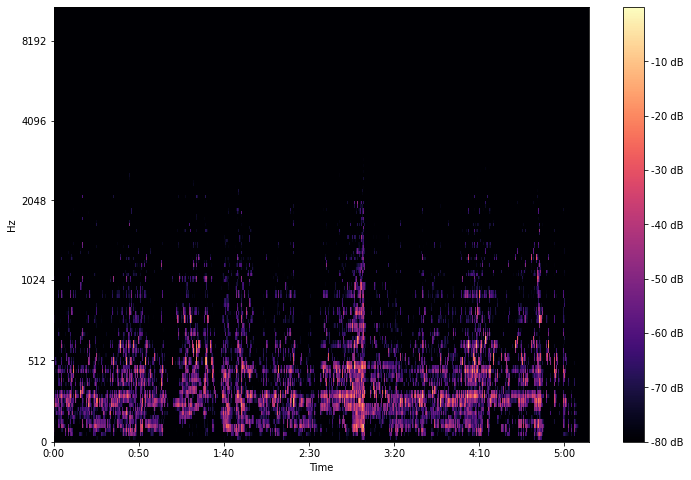

In [46]:
melspec = librosa.feature.melspectrogram(x, sr=sr, n_mels=128, n_fft=2048, hop_length=512) # fmin=20, fmax=16000)
melspec.shape

fig, ax = plt.subplots(figsize=(12,8))
melspec_db = librosa.amplitude_to_db(np.abs(melspec), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [47]:
melspec = melspec.T
melspec.shape

(13546, 128)

In [48]:
mel32 = lsa32.transform(melspec)
mel32.shape

(13546, 32)

In [53]:
new_melspec=[]
for i in range(mel32.shape[0]):
    if i%1000==0:
        print(i)
    v = mel32[i]
    for cv, sc in cluster_model.most_similar(v, topn=1):
        new_melspec.append(melspec_model[cv])
new_melspec = np.vstack(new_melspec)
new_melspec.shape

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


(13546, 32)

In [54]:
new_mel = lsa32.inverse_transform(new_melspec)
new_mel.shape

(13546, 128)

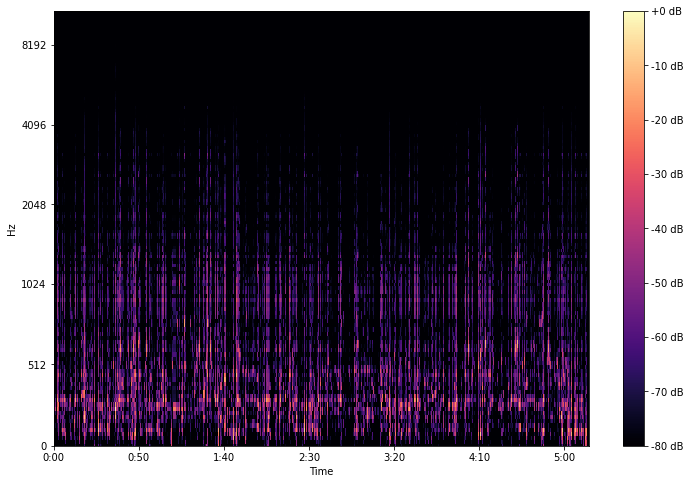

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
melspec_db = librosa.amplitude_to_db(np.abs(new_mel.T), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [57]:
n_fft=2048
n_iter=32
melspec_x = librosa.feature.inverse.mel_to_audio(new_mel.T, sr=sr, n_fft=n_fft, n_iter=n_iter)
sf.write('cluster_mel32_to_audio_beethoven.wav', melspec_x, sr, 'PCM_24')

In [ ]:
# try mapping the lower dim svd real vecs to binary vecs and see how many unique ones there are
# if there are less unique ones, then we have mapped specific sounds to a more general representation
# and might be able to use it as a vocabulary

In [32]:
# original 128 dim to binary
red = np.where(x<x.mean(), 0, 1)
sound_dict = {}
sound_idx = 0
for i in range(red.shape[0]):
    sound = ' '.join(['%d' % y for y in red[i, :]])
    if sound not in sound_dict:
        sound_dict[sound] = 'sound_%d' % sound_idx
        sound_idx += 1
len(sound_dict)

95461

In [34]:
lsa64_xred = np.where(lsa64_x<lsa64_x.mean(), 0, 1)
sound_dict = {}
sound_idx = 0
for i in range(lsa64_xred.shape[0]):
    sound = ' '.join(['%d' % y for y in lsa64_xred[i, :]])
    if sound not in sound_dict:
        sound_dict[sound] = 'sound_%d' % sound_idx
        sound_idx += 1
len(sound_dict)

97375

In [35]:
lsa32_xred = np.where(lsa32_x<lsa32_x.mean(), 0, 1)
sound_dict = {}
sound_idx = 0
for i in range(lsa32_xred.shape[0]):
    sound = ' '.join(['%d' % y for y in lsa32_xred[i, :]])
    if sound not in sound_dict:
        sound_dict[sound] = 'sound_%d' % sound_idx
        sound_idx += 1
len(sound_dict)

65938

In [38]:
lsa16_xred = np.where(lsa16_x<lsa16_x.mean(), 0, 1)
sound_dict16 = {}
sound_idx = 0
for i in range(lsa16_xred.shape[0]):
    sound = ' '.join(['%d' % y for y in lsa16_xred[i, :]])
    if sound not in sound_dict16:
        sound_dict16[sound] = 'sound_%d' % sound_idx
        sound_idx += 1
len(sound_dict16)

8549

In [37]:
lsa8_xred = np.where(lsa8_x<lsa8_x.mean(), 0, 1)
sound_dict = {}
sound_idx = 0
for i in range(lsa8_xred.shape[0]):
    sound = ' '.join(['%d' % y for y in lsa8_xred[i, :]])
    if sound not in sound_dict:
        sound_dict[sound] = 'sound_%d' % sound_idx
        sound_idx += 1
len(sound_dict)

169

In [ ]:
#Use 16 dim which maps 100K sounds to 8549 as a dictionary
#express songs as text sequences from the dict, load into keyed vecs model

In [40]:
sound_dict = {}
sound_idx = 0
texts = []
for fn in os.listdir(melspec_path):
    if not fn.endswith('.npy'):
        continue
    text = []
    fp = '%s/%s' % (melspec_path, fn)
    x = np.load(fp).T
    x = lsa16.transform(x)
    x = np.where(x < lsa16_x.mean(), 0, 1)
    for i in range(x.shape[0]):
        sound = ' '.join([str(y) % y for y in x[i, :]])
        if sound not in sound_dict:
            sound_dict[sound] = 'sound_%d' % sound_idx
            sound_idx += 1
        text.append(sound_dict[sound])
    texts.append(text)
            
print(len(sound_dict))

8548


In [42]:
with open('keyed_melspec_vecs16.txt', 'w') as o:
    o.write('%d 16\n' % len(sound_dict))
    for k,v in sound_dict.items():
        o.write('%s %s\n' % (v,k))

In [43]:
melspec_model = KeyedVectors.load_word2vec_format('keyed_melspec_vecs16.txt', binary=False)
fse_model = SIF(melspec_model)
_,_ = fse_model.train(IndexedList(texts))
fse_model.save('fse_melspec16.model')

In [49]:
idx_nm={}
i=0
for fn in os.listdir(melspec_path):
    if not fn.endswith('.npy'):
        continue
    idx_nm[i] = fn
    i+=1

In [51]:
for i in range(fse_model.sv.vectors.shape[0]):
    print('\n', idx_nm[i])
    for j,sc in fse_model.sv.most_similar(i, topn=3):
        print('   %.6f\t%s' % (sc, idx_nm[j]))


 best_friend_22050sr_128mels_2048fft_512hop.npy
   0.738934	be_glorified_22050sr_128mels_2048fft_512hop.npy
   0.636767	im_a_male_22050sr_128mels_2048fft_512hop.npy
   0.616650	be_with_me_22050sr_128mels_2048fft_512hop.npy

 be_with_me_22050sr_128mels_2048fft_512hop.npy
   0.726178	spanky_take_nothing_22050sr_128mels_2048fft_512hop.npy
   0.721097	im_a_male_22050sr_128mels_2048fft_512hop.npy
   0.616650	best_friend_22050sr_128mels_2048fft_512hop.npy

 being_the_fool_22050sr_128mels_2048fft_512hop.npy
   0.498638	non_sequitur_i_22050sr_128mels_2048fft_512hop.npy
   0.392734	noise_not_war_22050sr_128mels_2048fft_512hop.npy
   0.353209	better_life_22050sr_128mels_2048fft_512hop.npy

 beautiful_sky_22050sr_128mels_2048fft_512hop.npy
   0.555707	non_sequitur_i_22050sr_128mels_2048fft_512hop.npy
   0.224773	waiting_for_ya_22050sr_128mels_2048fft_512hop.npy
   0.220456	beings_from_a_strange__22050sr_128mels_2048fft_512hop.npy

 beethoven_sonata_no_8__20050sr_128mels_2048fft_512hop.npy
   0.7

##### Visualize the clustering of sounds in the different feature space dimensions

In [62]:
x_bee = np.load('melspec/beethoven_sonata_no_8__20050sr_128mels_2048fft_512hop.npy').T
idx = np.arange(x_bee.shape[0])
np.random.shuffle(idx)
x_bee = x_bee[idx][:5000]


x_sky = np.load('melspec/beautiful_sky_22050sr_128mels_2048fft_512hop.npy').T
idx = np.arange(x_sky.shape[0])
np.random.shuffle(idx)
x_sky = x_sky[idx][:5000]


x_seq = np.load('melspec/non_sequitur_i_22050sr_128mels_2048fft_512hop.npy').T
idx = np.arange(x_seq.shape[0])
np.random.shuffle(idx)
x_seq = x_seq[idx][:5000]


x_noi = np.load('melspec/noise_not_war_22050sr_128mels_2048fft_512hop.npy').T
idx = np.arange(x_noi.shape[0])
np.random.shuffle(idx)
x_noi = x_noi[idx][:5000]

x = np.concatenate((x_bee, x_sky, x_seq, x_noi), axis=0)

In [63]:
components=2
perp=30
n_iter=1000

tsne = TSNE(n_components=components, verbose=1, perplexity=perp, n_iter=n_iter)
tsne_results = tsne.fit_transform(x)

vis_x = tsne_results[:,0]
vis_y = tsne_results[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18979 samples in 0.103s...
[t-SNE] Computed neighbors for 18979 samples in 20.488s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18979
[t-SNE] Computed conditional probabilities for sample 2000 / 18979
[t-SNE] Computed conditional probabilities for sample 3000 / 18979
[t-SNE] Computed conditional probabilities for sample 4000 / 18979
[t-SNE] Computed conditional probabilities for sample 5000 / 18979
[t-SNE] Computed conditional probabilities for sample 6000 / 18979
[t-SNE] Computed conditional probabilities for sample 7000 / 18979
[t-SNE] Computed conditional probabilities for sample 8000 / 18979
[t-SNE] Computed conditional probabilities for sample 9000 / 18979
[t-SNE] Computed conditional probabilities for sample 10000 / 18979
[t-SNE] Computed conditional probabilities for sample 11000 / 18979
[t-SNE] Computed conditional probabilities for sample 12000 / 18979
[t-SNE] Computed conditional probabilities for sa

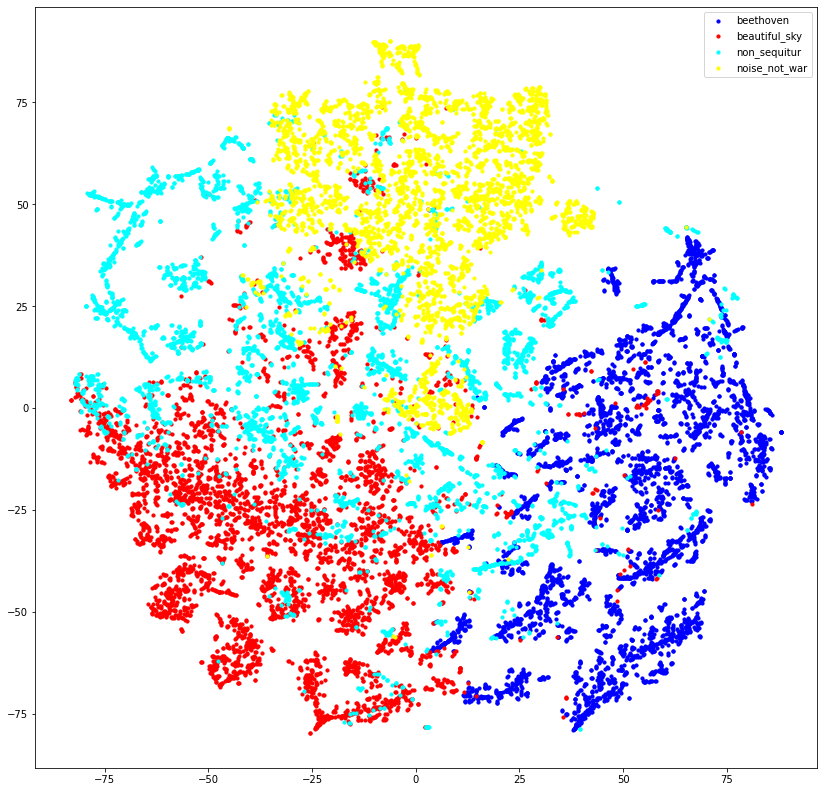

In [64]:
fig, ax = plt.subplots(figsize=(14,14))

ax.scatter(vis_x[:5000], vis_y[:5000], c = 'blue', label = 'beethoven', s=10)
ax.scatter(vis_x[5000:10001], vis_y[5000:10001], c = 'red', label = 'beautiful_sky', s=10)
ax.scatter(vis_x[10001:15001], vis_y[10001:15001], c = 'aqua', label = 'non_sequitur', s=10)
ax.scatter(vis_x[15001:], vis_y[15001:], c = 'yellow', label = 'noise_not_war', s=10)

ax.legend()
plt.show()

0.9999362715770985
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18979 samples in 0.082s...
[t-SNE] Computed neighbors for 18979 samples in 11.205s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18979
[t-SNE] Computed conditional probabilities for sample 2000 / 18979
[t-SNE] Computed conditional probabilities for sample 3000 / 18979
[t-SNE] Computed conditional probabilities for sample 4000 / 18979
[t-SNE] Computed conditional probabilities for sample 5000 / 18979
[t-SNE] Computed conditional probabilities for sample 6000 / 18979
[t-SNE] Computed conditional probabilities for sample 7000 / 18979
[t-SNE] Computed conditional probabilities for sample 8000 / 18979
[t-SNE] Computed conditional probabilities for sample 9000 / 18979
[t-SNE] Computed conditional probabilities for sample 10000 / 18979
[t-SNE] Computed conditional probabilities for sample 11000 / 18979
[t-SNE] Computed conditional probabilities for sample 12000 / 18979
[t-SNE] Computed conditional p

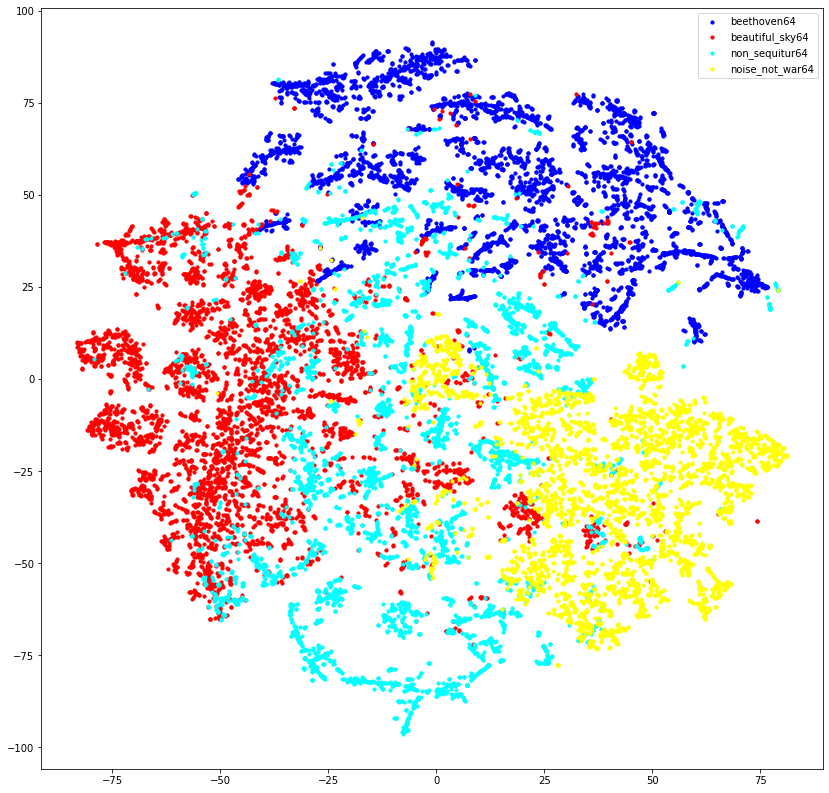

In [65]:
lsa64_x = lsa64.fit_transform(x)
print(sum(lsa64.explained_variance_ratio_))

tsne_results = tsne.fit_transform(lsa64_x)
vis_x = tsne_results[:,0]
vis_y = tsne_results[:,1]

fig, ax = plt.subplots(figsize=(14,14))

ax.scatter(vis_x[:5000], vis_y[:5000], c = 'blue', label = 'beethoven64', s=10)
ax.scatter(vis_x[5000:10001], vis_y[5000:10001], c = 'red', label = 'beautiful_sky64', s=10)
ax.scatter(vis_x[10001:15001], vis_y[10001:15001], c = 'aqua', label = 'non_sequitur64', s=10)
ax.scatter(vis_x[15001:], vis_y[15001:], c = 'yellow', label = 'noise_not_war64', s=10)

ax.legend()
plt.show()

0.998569331743056
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.083s...
[t-SNE] Computed neighbors for 20000 samples in 7.156s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional pro

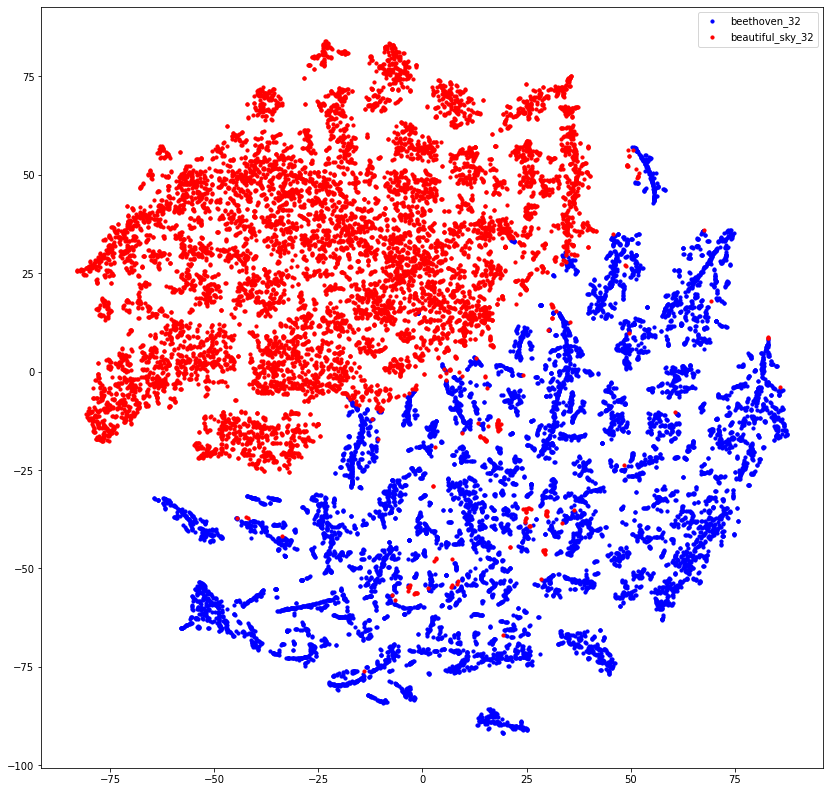

In [60]:
lsa32_x = lsa32.fit_transform(x)
print(sum(lsa32.explained_variance_ratio_))

tsne_results = tsne.fit_transform(lsa32_x)
vis_x = tsne_results[:,0]
vis_y = tsne_results[:,1]

fig, ax = plt.subplots(figsize=(14,14))

ax.scatter(vis_x[:5000], vis_y[:5000], c = 'blue', label = 'beethoven32', s=10)
ax.scatter(vis_x[5000:10001], vis_y[5000:10001], c = 'red', label = 'beautiful_sky32', s=10)
ax.scatter(vis_x[10001:15001], vis_y[10001:15001], c = 'aqua', label = 'non_sequitur32', s=10)
ax.scatter(vis_x[15001:], vis_y[15001:], c = 'yellow', label = 'noise_not_war32', s=10)

ax.legend()
plt.show()

0.9801921928301454
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.047s...
[t-SNE] Computed neighbors for 20000 samples in 3.593s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional pr

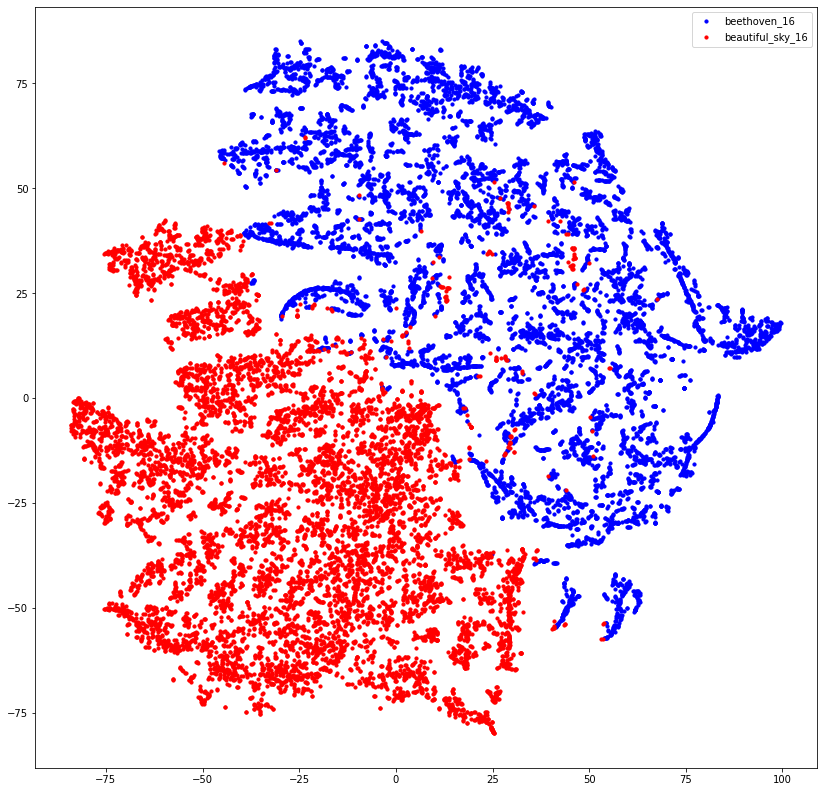

In [61]:
lsa16_x = lsa16.fit_transform(x)
print(sum(lsa16.explained_variance_ratio_))

tsne_results = tsne.fit_transform(lsa16_x)
vis_x = tsne_results[:,0]
vis_y = tsne_results[:,1]

fig, ax = plt.subplots(figsize=(14,14))

ax.scatter(vis_x[:10000], vis_y[:10000], c = 'blue', label = 'beethoven_16', s=10)
ax.scatter(vis_x[10000:], vis_y[10000:], c = 'red', label = 'beautiful_sky_16', s=10)

ax.legend()
plt.show()

In [ ]:
lsa8_x = lsa8.fit_transform(x)
print(sum(lsa8.explained_variance_ratio_))

tsne_results = tsne.fit_transform(lsa8_x)
vis_x = tsne_results[:,0]
vis_y = tsne_results[:,1]

fig, ax = plt.subplots(figsize=(14,14))

ax.scatter(vis_x[:10000], vis_y[:10000], c = 'blue', label = 'beethoven_8', s=10)
ax.scatter(vis_x[10000:], vis_y[10000:], c = 'red', label = 'beautiful_sky_8', s=10)

ax.legend()
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.017s...
[t-SNE] Computed neighbors for 10000 samples in 2.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.155670
[t-SNE] KL divergence after 1000 iterations: 1.439018


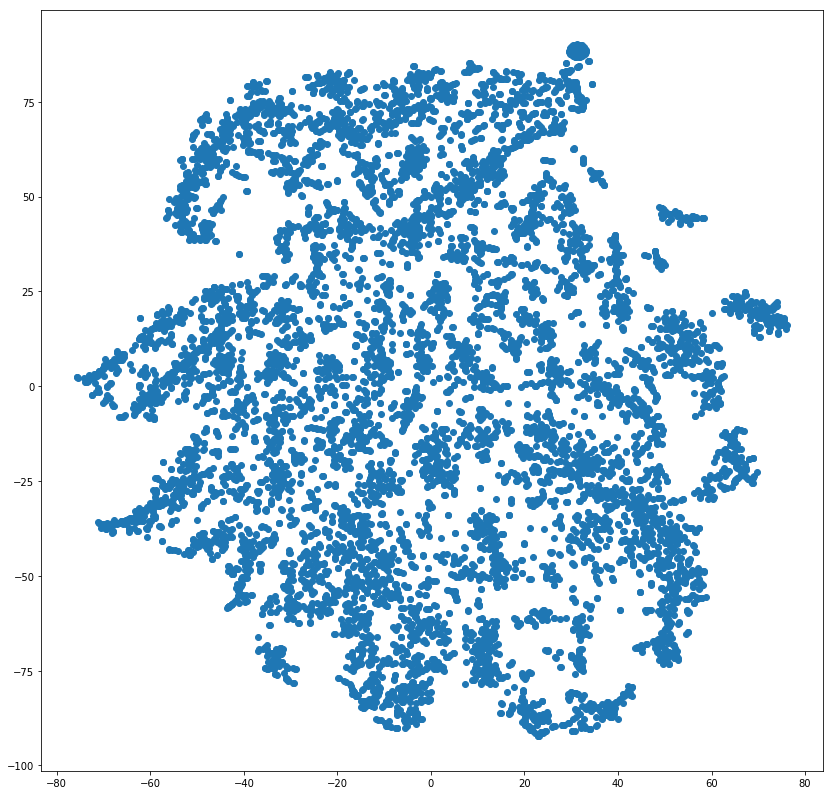

In [93]:
tsne = TSNE(n_components=components, verbose=1, perplexity=perp, n_iter=n_iter)
tsne_results = tsne.fit_transform(lsa32_x[:10000,:])

vis_x = tsne_results[:,0]
vis_y = tsne_results[:,1]
plt.figure(figsize=(14,14))
plt.scatter(vis_x, vis_y)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 1.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.536713
[t-SNE] KL divergence after 1000 iterations: 1.395982


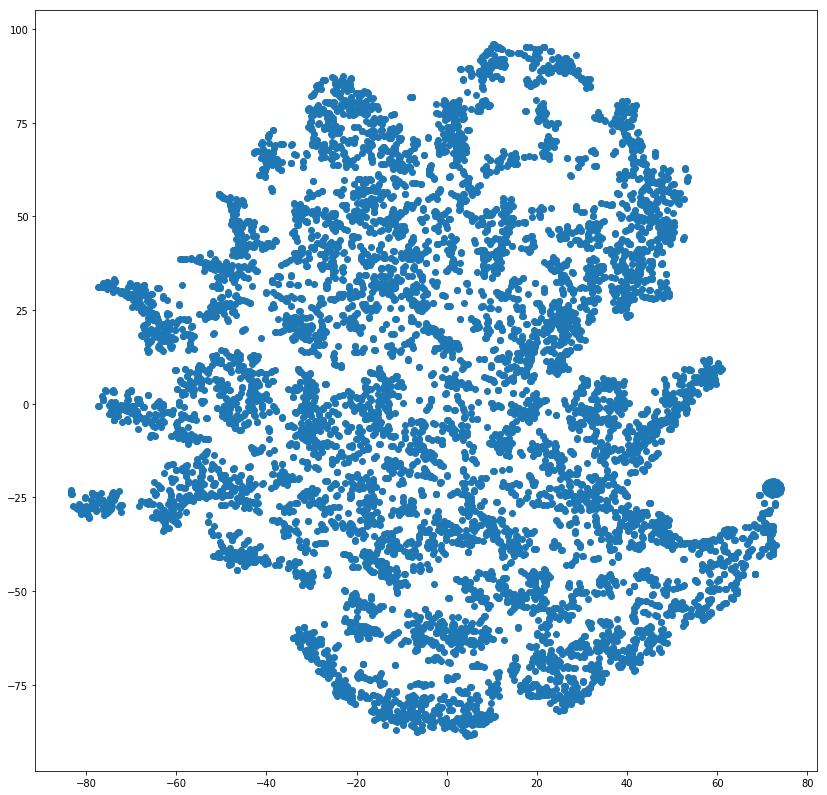

In [95]:
tsne = TSNE(n_components=components, verbose=1, perplexity=perp, n_iter=n_iter)
tsne_results = tsne.fit_transform(lsa16_x[:10000,:])

vis_x = tsne_results[:,0]
vis_y = tsne_results[:,1]
plt.figure(figsize=(14,14))
plt.scatter(vis_x, vis_y)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 0.498s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.803253
[t-SNE] KL divergence after 1000 iterations: 1.281222


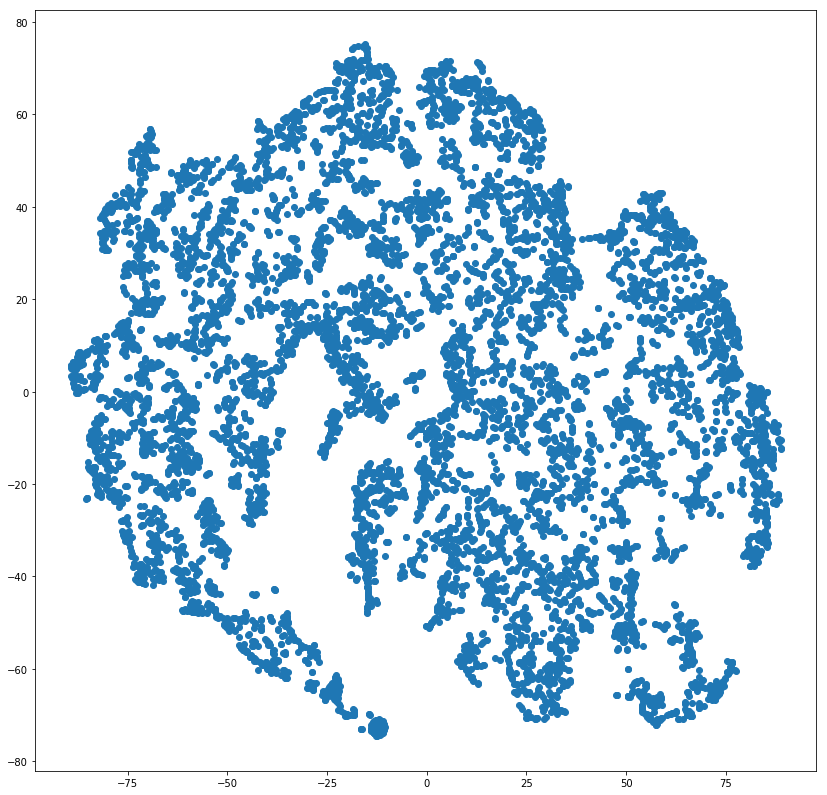

In [97]:
tsne = TSNE(n_components=components, verbose=1, perplexity=perp, n_iter=n_iter)
tsne_results = tsne.fit_transform(lsa8_x[:10000,:])

vis_x = tsne_results[:,0]
vis_y = tsne_results[:,1]
plt.figure(figsize=(14,14))
plt.scatter(vis_x, vis_y)
plt.show()

##### Clustering - Use clustering to attempt to identify the number of 'primal sounds' in the data. Then a 'vocabulary' of sounds could be created which would reduce the input/output space and allow NLP techniques to be used.

In [98]:
#The V-measure is the harmonic mean between homogeneity and completeness:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, normalized_mutual_info_score

(array([0.00419896, 0.00446769, 0.00648319, 0.00178036, 0.00332557,
        0.00597931, 0.00131007, 0.00107493, 0.00275452, 0.00335917,
        0.0024186 , 0.00413177, 0.00107493, 0.00100775, 0.00057106,
        0.00073902, 0.00073902, 0.00094057, 0.00167958, 0.00749094,
        0.00104134, 0.00151162, 0.00100775, 0.00332557, 0.00174677,
        0.00036951, 0.00043669, 0.00033592, 0.00036951, 0.00033592,
        0.0004031 , 0.00053747, 0.00053747, 0.00036951, 0.0004031 ,
        0.00033592, 0.00047028, 0.00100775, 0.0016124 , 0.00036951,
        0.00174677, 0.00047028, 0.00047028, 0.00057106, 0.00033592,
        0.00057106, 0.00154522, 0.00043669, 0.00083979, 0.00057106,
        0.00033592, 0.00033592, 0.00036951, 0.00033592, 0.00033592,
        0.00033592, 0.00036951, 0.00033592, 0.00033592, 0.00033592,
        0.00036951, 0.00033592, 0.00033592, 0.00033592, 0.00047028,
        0.00036951, 0.00033592, 0.00033592, 0.00033592, 0.00036951,
        0.00033592, 0.00033592, 0.00036951, 0.00

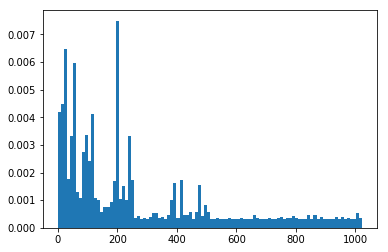

In [109]:
num_primal_sounds = 1024

cluster_model = AgglomerativeClustering(n_clusters=num_primal_sounds, affinity='euclidean', linkage='average')
cluster_model = cluster_model.fit(x[:10000])
plt.hist([l for l in cluster_model.labels_ if not l==5], density=True, bins=100)

In [108]:
labs=cluster_model.labels_.tolist()
max(set(labs), key=labs.count)

5

In [ ]:
plt.hist([l for l in cluster_model.labels_ if not l==5], density=True, bins=100)

In [62]:
sample_path = '%s/Beethoven_Sonata_No_8_.mp3' % mp3com_path
#sample_path = '%s/Non_Sequitur_I.mp3' % mp3com_path
#sample_path = '%s/Be_With_Me.mp3' % mp3com_path
#sample_path = '%s/Beautiful_Sky.mp3' % mp3com_pathw
#sample_path = '%s/pink_noise.mp3' % data_path
#sample_path = '%s/BEINGS_FROM_A_STRANGE_.mp3' % mp3com_path #synth techno
#sample_path = '%s/Believe (4).mp3' % mp3com_path #synth techno
#sample_path = '%s/Best_Friend.mp3' % mp3com_path #what the?
#sample_path = '%s/Better_Life.mp3' % mp3com_path #lo fi rock
#sample_path = '%s/Im_a_Male.mp3' % mp3com_path #lounge
#sample_path = '%s/Noise_Not_War.mp3' % mp3com_path #crust
#sample_path = '%s/spanky_take_nothing.mp3' % mp3com_path #talking
#sample_path = '%s/The_Fisherman.mp3' % mp3com_path #electronic
#sample_path = '%s/Waiting_for_ya.mp3' % mp3com_path

In [63]:
x, sr = librosa.load(sample_path)
x.shape, sr

c:\ml\env\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


((6935040,), 22050)

In [ ]:
## Sanity check that indeed we understood the underlying pipeline
#n_fft, hop_length, n_mels = 2048, 512, 128

#S1 = librosa.feature.melspectrogram(x, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

## is equivalent to:
#fft_windows = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)   #gives freqxtime with amp values
#magnitude = np.abs(fft_windows)**2   #squared amplitude = power?, or can convert to decibels
#mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)  #the triangular mel filters
#S2 = mel.dot(magnitude)   #convert freq to mel log scale

#assert (S2 == S1).all()

In [64]:
#melspec = librosa.feature.melspectrogram(x, sr=sr, n_mels=1024, n_fft=2048, fmin=20, fmax=16000)
#256 sounds okay, 512 is better
melspec = librosa.feature.melspectrogram(x, sr=sr, n_mels=128, n_fft=2048, hop_length=512) # fmin=20, fmax=16000)
melspec.shape

(128, 13546)

In [65]:
np.save('../data/audio_features/melspec/classical/beethoven_128_2048_512.npy', melspec)

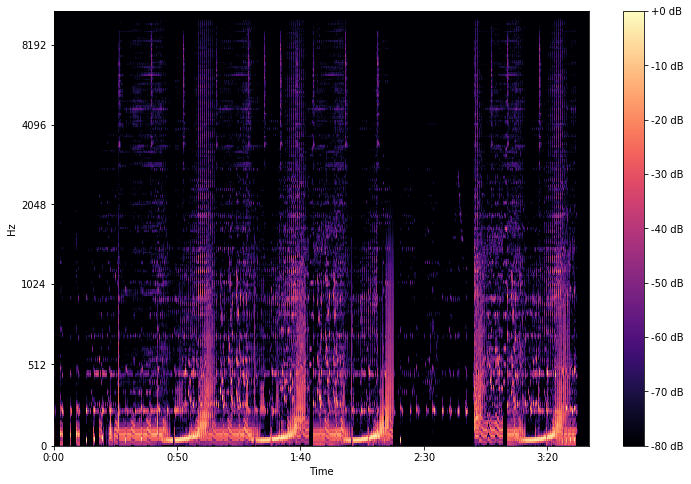

In [59]:
fig, ax = plt.subplots(figsize=(12,8))
melspec_db = librosa.amplitude_to_db(np.abs(melspec), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

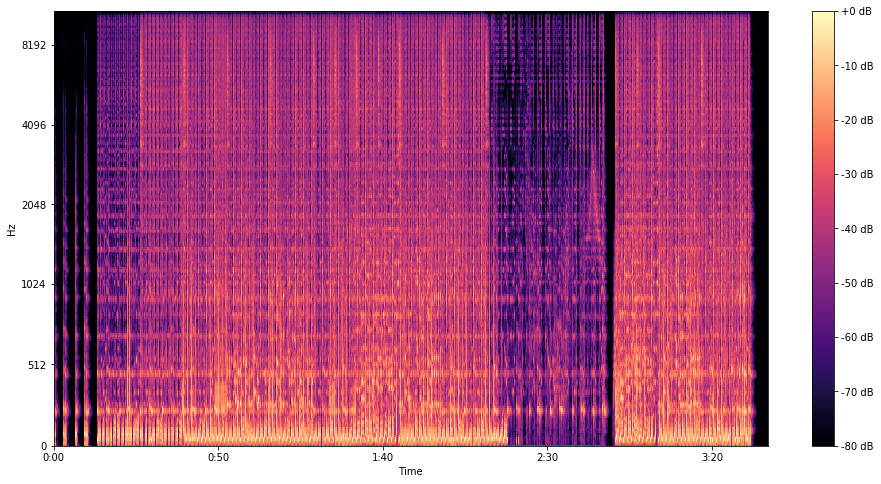

In [60]:
fig, ax = plt.subplots(figsize=(16,8))
melspec_db = librosa.power_to_db(np.abs(melspec), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [143]:
import time
start = time.time()
n_fft=2048
n_iter=32
melspec_x = librosa.feature.inverse.mel_to_audio(melspec[:,:1000], sr=sr, n_fft=n_fft, n_iter=n_iter)
sf.write('mel256_to_audio_beethoven.wav', melspec_x, sr, 'PCM_24')
print((time.time()-start)/60)

0.25536028544108075


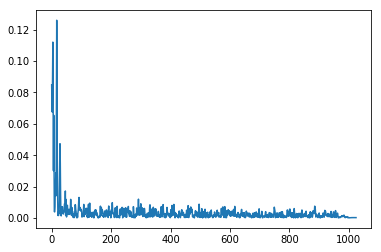

In [104]:
#The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT)
# over short overlapping windows. This function returns a complex-valued matrix D such that np.abs(D[f, t])
# is the magnitude of frequency bin f at frame t, and np.angle(D[f, t]) is the phase of frequency bin f at frame t.
# the value is amplitude - will convert to decibel

#The ints t and f can be converted to physical units by utility functions frames_to_sample and fft_frequencies.

n_fft = 2048
#The number of rows in the STFT matrix D is (1 + n_fft/2). The default value, n_fft=2048 samples, corresponds
# to a physical duration of 93 milliseconds at a sample rate of 22050 Hz, i.e. the default sample rate in librosa.
# This value is well adapted for music signals. However, in speech processing, the recommended value is 512,
# corresponding to 23 milliseconds at a sample rate of 22050 Hz.

stft_x = np.abs(librosa.stft(x[n_fft*100:n_fft*101], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(stft_x);

In [85]:
mfcc = librosa.feature.mfcc(x, sr=sr)#, n_mfcc=20)
mfcc.shape

(20, 13546)

In [99]:
hop_length=512
x_chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
x_chromagram.shape

(12, 25063)

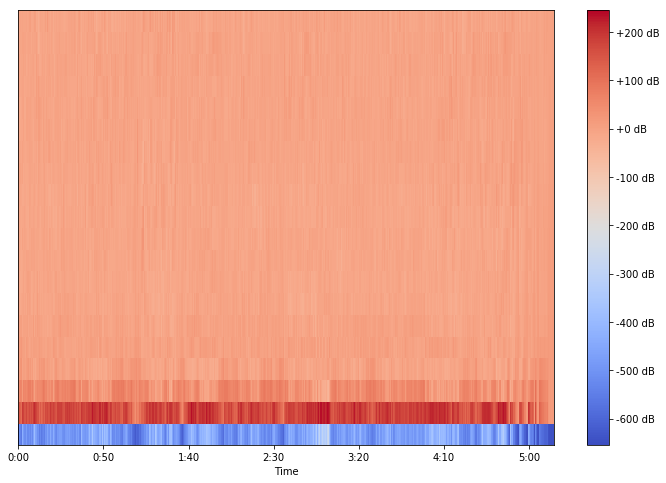

In [86]:
fig, ax = plt.subplots(figsize=(12,8))
img = librosa.display.specshow(mfcc, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [15]:
prev_ms = melspec[:,0]
for i in range(1,13):
    ms = melspec[:,i*1000]
    dif = np.sum(np.power((ms-prev_ms), 2))
    print(dif, ms)

0.017766882 [1.4072148e-03 2.0308865e-03 1.7755268e-02 7.4749880e-02 2.8448723e-02
 1.9311102e-02 2.3387887e-02 2.1122400e-02 2.2631800e-02 4.5717347e-02
 2.3022447e-02 1.4511843e-02 2.1918168e-02 5.0699618e-02 2.4404315e-02
 5.0051130e-02 3.7802900e-03 1.0006725e-03 5.5867981e-04 2.6664976e-04
 4.2337347e-03 8.3315913e-03 8.0443965e-03 1.4436631e-03 5.4812193e-05
 5.1763398e-04 1.8297366e-03 3.7480131e-04 6.9602422e-04 1.8112739e-03
 2.8520965e-03 6.7307439e-04 1.6657932e-05 4.9885261e-05 4.2096923e-05
 8.9496811e-05 9.2947920e-04 1.6727487e-03 6.2369283e-05 1.5617006e-05
 2.4772341e-06 3.1639316e-05 5.8964717e-05 3.4517722e-04 3.2310057e-04
 9.1051425e-06 1.4622683e-05 5.6200965e-06 9.8887795e-05 8.8657362e-05
 6.4594942e-06 9.3543031e-06 8.1928183e-06 3.3385099e-05 8.9101577e-06
 1.1817431e-05 2.3362466e-06 3.1097730e-07 6.5537097e-07 3.0963423e-07
 3.2662581e-06 4.0875975e-06 1.2806490e-07 2.1854373e-07 3.6550514e-07
 6.8896588e-06 1.8661417e-06 1.3237153e-07 1.3849638e-07 8.499717

In [17]:
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

In [18]:
cluster_model = AgglomerativeClustering(n_clusters=1000, affinity='euclidean', linkage='average')
cluster_model = cluster_model.fit(melspec.T)

In [24]:
labs = [l for l in cluster_model.labels_ if not l==16]
len(labs)

5045

(array([0.00206351, 0.00422623, 0.01944462, 0.00119049, 0.0010516 ,
        0.00255955, 0.00194446, 0.00130954, 0.00275796, 0.00263891,
        0.00255955, 0.00250002, 0.00113096, 0.00063493, 0.00075397,
        0.00150795, 0.0013889 , 0.00216272, 0.00093255, 0.0011508 ,
        0.00059524, 0.0018651 , 0.00083334, 0.00275796, 0.00055556,
        0.0003373 , 0.00039683, 0.00027778, 0.00710324, 0.00045635,
        0.0003373 , 0.00051588, 0.00027778, 0.00035715, 0.00031746,
        0.00097223, 0.00140874, 0.00031746, 0.00093255, 0.00041667,
        0.00093255, 0.00047619, 0.0011508 , 0.00079366, 0.00132938,
        0.00255955, 0.00035715, 0.00224208, 0.00031746, 0.00067461,
        0.00019841, 0.00021826, 0.00021826, 0.00021826, 0.0003373 ,
        0.00019841, 0.0002381 , 0.00019841, 0.00021826, 0.00019841,
        0.00019841, 0.00019841, 0.00021826, 0.0002381 , 0.00019841,
        0.00021826, 0.00019841, 0.00021826, 0.00019841, 0.00019841,
        0.0002381 , 0.00025794, 0.00027778, 0.00

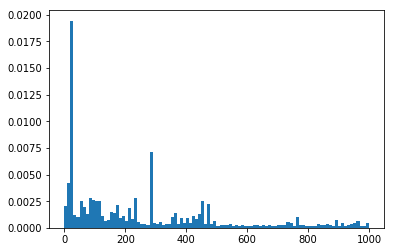

In [25]:
labs = [l for l in cluster_model.labels_ if not l==16]
print(len(labs))
plt.hist(labs, density=True, bins=100)

In [157]:
components=2
perp=30
n_iter=1000

tsne = TSNE(n_components=components, verbose=1, perplexity=perp, n_iter=n_iter)
tsne_results = tsne.fit_transform(melspec.T)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13546 samples in 0.572s...
[t-SNE] Computed neighbors for 13546 samples in 74.555s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13546
[t-SNE] Computed conditional probabilities for sample 2000 / 13546
[t-SNE] Computed conditional probabilities for sample 3000 / 13546
[t-SNE] Computed conditional probabilities for sample 4000 / 13546
[t-SNE] Computed conditional probabilities for sample 5000 / 13546
[t-SNE] Computed conditional probabilities for sample 6000 / 13546
[t-SNE] Computed conditional probabilities for sample 7000 / 13546
[t-SNE] Computed conditional probabilities for sample 8000 / 13546
[t-SNE] Computed conditional probabilities for sample 9000 / 13546
[t-SNE] Computed conditional probabilities for sample 10000 / 13546
[t-SNE] Computed conditional probabilities for sample 11000 / 13546
[t-SNE] Computed conditional probabilities for sample 12000 / 13546
[t-SNE] Computed conditional probabilities for sa

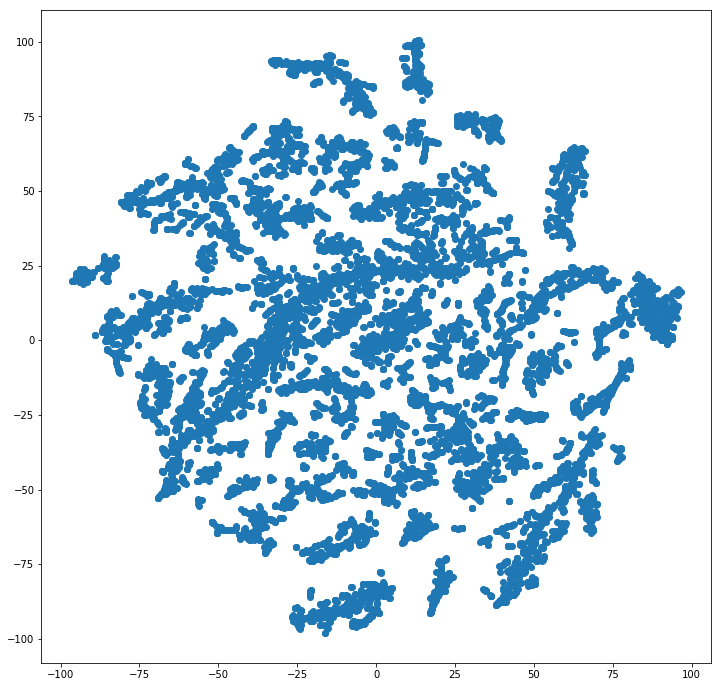

In [158]:
vis_x = tsne_results[:,0]
vis_y = tsne_results[:,1]
plt.figure(figsize=(12,12))
plt.scatter(vis_x, vis_y)
plt.show()

In [29]:
from sklearn.decomposition import TruncatedSVD

In [33]:
svd = TruncatedSVD(n_components=512, n_iter=20, random_state=42)
melspec_reduced = svd.fit_transform(melspec)
print(svd.explained_variance_ratio_.sum())
melspec_reduced.shape

0.9999991


(128, 128)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 128 samples in 0.000s...
[t-SNE] Computed neighbors for 128 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 128 / 128
[t-SNE] Mean sigma: 0.000284
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.695988
[t-SNE] KL divergence after 900 iterations: 0.211282


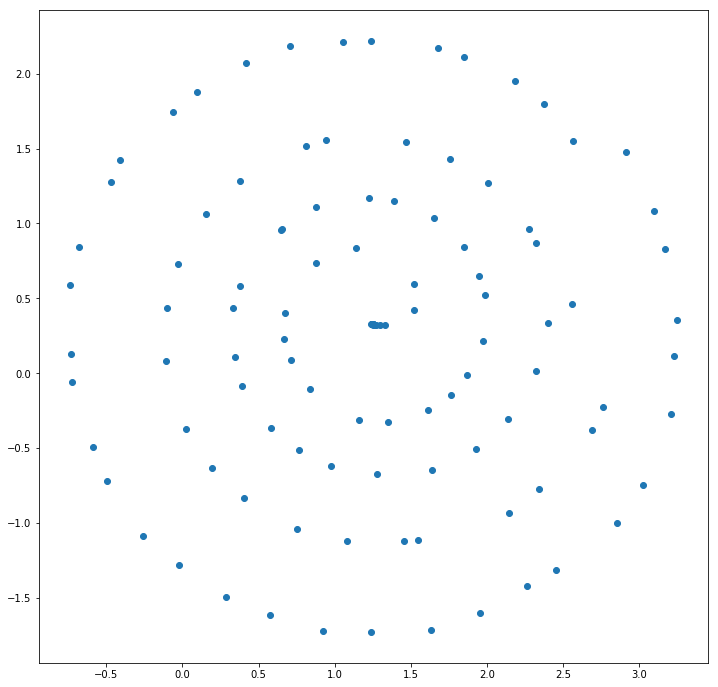

In [34]:
components=2
perp=30
n_iter=1000

tsne = TSNE(n_components=components, verbose=1, perplexity=perp, n_iter=n_iter)
tsne_results = tsne.fit_transform(melspec_reduced.T)
vis_x = tsne_results[:,0]
vis_y = tsne_results[:,1]
plt.figure(figsize=(12,12))
plt.scatter(vis_x, vis_y)
plt.show()

In [145]:
import PIL
from PIL import Image

In [263]:
im = Image.open("images/gosper.png").convert('L')
im_arr = np.array(im, dtype=np.float32)  #/ 255.0
im_arr = np.flipud(im_arr)

im_arr.shape

(256, 273)

In [208]:
combine = melspec[:,3000:3000+im_arr.shape[1]]

In [226]:
combine.mean()

20.168776

In [253]:
im_norm = np.clip(im_arr - im_arr.mean(), 0, 255)

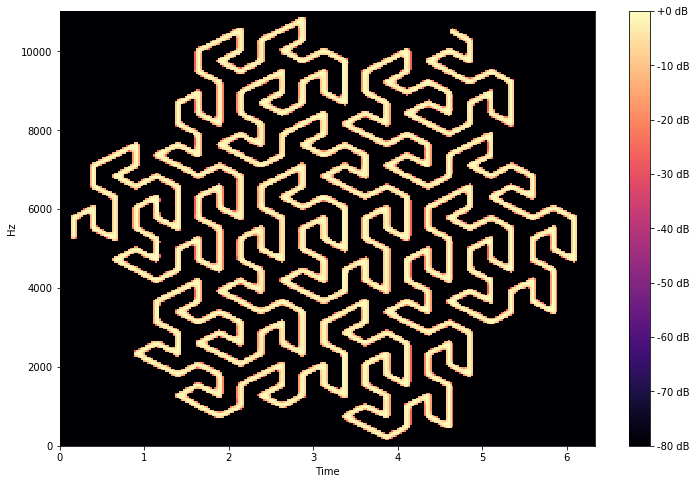

In [264]:
fig, ax = plt.subplots(figsize=(12,8))
im_arr_db = librosa.amplitude_to_db(im_arr, ref=np.max)
#im_arr_db = librosa.amplitude_to_db(np.clip(im_arr - 0.01, 0.0, 1.0), ref=np.max)
img = librosa.display.specshow(im_arr_db, x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [266]:
n_fft=2048
n_iter=32
pic_x = librosa.feature.inverse.mel_to_audio(im_arr, sr=sr, n_fft=n_fft, n_iter=n_iter)
sf.write('gosper.wav', pic_x, sr, 'PCM_24')

KeyboardInterrupt: 

In [164]:
ms

array([[1.98782558e+01, 2.82042313e+01, 4.49855766e+01, ...,
        1.17969780e+02, 1.79809814e+02, 9.21373596e+01],
       [7.92953205e+00, 4.08772659e+01, 4.43190727e+01, ...,
        5.50593987e+01, 8.68599777e+01, 4.90137863e+01],
       [2.85805130e+01, 4.58418808e+01, 3.96407814e+01, ...,
        2.40057373e+01, 2.99134388e+01, 1.70094662e+01],
       ...,
       [3.11892092e-01, 2.30253696e-01, 1.72750145e-01, ...,
        4.65730131e-01, 3.73648763e-01, 2.68434554e-01],
       [1.24968655e-01, 1.59007579e-01, 1.18844137e-01, ...,
        2.55661041e-01, 2.07284138e-01, 1.75685361e-01],
       [1.67832021e-02, 2.29172613e-02, 1.65452212e-02, ...,
        2.07854975e-02, 2.31795181e-02, 2.54682563e-02]], dtype=float32)

In [165]:
np.ones(im_arr.shape)*0.5 + im_arr

array([[0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       ...,
       [0.5       , 0.5       , 0.54313725, ..., 0.5       , 0.5       ,
        0.5       ],
       [0.67647059, 0.55490196, 0.65294118, ..., 0.53529412, 0.5       ,
        0.5       ],
       [0.69215686, 0.53529412, 0.58235294, ..., 0.54313725, 0.53921569,
        0.5       ]])